# Data Colletction

This notebook collects data from Yahoo finance using APIs and loads data from excel sheets downloaded from websites

Collect the following data 
1. equity (snp500 + world)
2. FI (T-bill+corpbonds index)
3. commodity (commodity index)
4. gold (london gold index)
5. long-vol (eurohedge log vol)   


1. '^SP500TR' (total return inc. div, oldest up to 1988) + 'EEM' (oldest up to 14 apr 2003)
2. 'IEF' (oldest up to 2002) + 'AGG' (up to 29 sep 2003 !dividend distributed)
3. 'BCOM' (up to 1991)
4. 'LBMA Gold Price' excel (1988) -  https://www.gold.org/goldhub/data/gold-prices
5. 'Euro hedge long-vol' excel (2005, monthly pricing!) - https://www.eurekahedge.com/Indices/IndexView/Eurekahedge/640/CBOE-Eurekahedge-Long-Volatility-Hedge-Fund-Index

### Date Range
2003-9-29
2021-9-31

In [1]:
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import datetime
import requests_cache

import calendar

import numpy as np, pandas as pd

# plots
import matplotlib.pyplot as plt
import seaborn as sns

### Data from Yahoo finance

In [2]:
# list of tickers required from yahoo finance
tickers = ['^SP500TR','EEM','IEF' , 'AGG','^BCOM']

In [3]:
# pd datareader with yahoo finance, caching query to sql lite file
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

start = datetime.datetime(2003, 9, 29)

end = datetime.datetime(2021, 10, 1)
data = web.DataReader(tickers, 'yahoo', start, end,session=session)

# use adjusted close as daily price
data = data['Adj Close']

data.head(3)

Symbols,^SP500TR,EEM,IEF,AGG,^BCOM
Date,,,,,
2003-09-29,1462.199951,10.932035,52.032452,57.497868,120.430000
2003-09-30,1446.770020,10.897560,52.536022,57.796093,120.900002
2003-10-01,1479.229980,11.183769,52.769112,57.767990,121.139999


In [4]:
# get dividends for AGG
div = web.DataReader('AGG', 'yahoo-dividends', start, end,session=session)
div.head(3)

,action,value
2021-10-01,DIVIDEND,0.180
2021-09-01,DIVIDEND,0.167
2021-08-02,DIVIDEND,0.167


# Data from Websites

#### Extract for Long Volatility

In [5]:
# percentage change is already in excel, so we can skip one step
data_lv = pd.read_excel('./data/long-vol.xlsx')  
data_lv.columns = data_lv.iloc[2]
data_lv = data_lv[3:].set_index('ReturnDate')['Index']

# set date as index
data_lv.index = pd.to_datetime(data_lv.index)

# upsample month returns to daily return by averaging
data_lv = data_lv.resample('24h').ffill()
days = [calendar.monthrange(idx.year, idx.month)[1] for idx, x in data_lv.iteritems()]
data_lv = data_lv/days

#### Extract for Gold

In [6]:
data_gold = pd.read_excel('./data/gold.xlsx',sheet_name='Daily_Indexed')
data_gold = data_gold[['Name', 'US dollar']].set_index('Name')

### Compile Data
- yahoo ticker
- long vol
- gold

create one table

In [7]:
# add dividends to AGG price
data = pd.concat([data, div['value']],axis=1)
data.AGG = data.AGG + data.value.fillna(0)
data.drop(columns='value',inplace=True)

In [49]:
# combine yahoo,bcom,gold
df = pd.concat([data,data_gold,data_lv],axis=1).dropna()
df.columns = ['SNP', 
              'EEM', 
              'IEF', 
              'AGG', 
              'BCM', 
              'GLD', 
              'LOV']

#find % difference and log difference
df = df.pct_change().apply(lambda x: np.log(1+x))

print('% log difference Prices\n\n')
df.head(3)

% log difference Prices




,SNP,EEM,IEF,AGG,BCM,GLD,LOV
2004-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-02,-0.000866,-0.001477,-0.002259,-0.003294,-0.031172,0.002983,0.0
2004-12-03,0.000713,0.004525,0.009949,0.005784,-0.000413,-0.012305,0.0


In [50]:
# compile price data only
df_px = pd.concat([data,data_gold,data_lv],axis=1).dropna()
df_px.columns = ['SNP', 
                  'EEM', 
                  'IEF', 
                  'AGG', 
                  'BCM', 
                  'GLD', 
                  'LOV']

In [51]:
print('Share and Index Prices')
df_px.head(3)

Share and Index Prices


,SNP,EEM,IEF,AGG,BCM,GLD,LOV
2004-12-01,1766.900024,15.839630,54.357414,59.812436,149.880005,157.35,3.225806
2004-12-02,1765.369995,15.816259,54.234745,59.615761,145.279999,157.82,3.225806
2004-12-03,1766.630005,15.887982,54.777012,59.961605,145.220001,155.89,3.225806


# EDA

### Variance

In [11]:
df.var()*250

SNP    0.037952
EEM    0.086088
IEF    0.004088
AGG    0.002720
BCM    0.027031
GLD    0.032436
LOV    0.031646
dtype: float64

### Standard Deviation (Volatility)

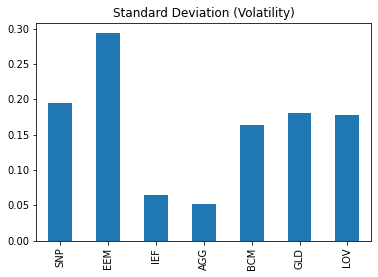

In [12]:
sd = df.std()*np.sqrt(250)
sd.plot(kind='bar')
plt.title('Standard Deviation (Volatility)');

> __volatility__  
> - Fixed income (i.e. IEF, AGG ) have the lowest. Although interesting that investment grade bonds have lower vol than EEM however the dividends are distributed
> - Commodities (BCM, LOV) have twice as much 
> - Equity has 3 times as much as fixed income 

### Covariance

In [13]:
# create the covariance matrix. 
# this will be used later in portfolio construction
cov_matrix = df.cov()
cov_matrix

,SNP,EEM,IEF,AGG,BCM,GLD,LOV
SNP,1.518060e-04,1.936971e-04,-2.051703e-05,-3.351474e-06,4.335085e-05,2.840239e-06,4.312711e-07
EEM,1.936971e-04,3.443514e-04,-2.610095e-05,-3.623782e-06,7.875011e-05,1.826943e-05,7.060554e-07
IEF,-2.051703e-05,-2.610095e-05,1.635160e-05,8.439181e-06,-7.774529e-06,3.597607e-06,7.444790e-07
AGG,-3.351474e-06,-3.623782e-06,8.439181e-06,1.087898e-05,1.129888e-07,2.412357e-06,1.109466e-06
BCM,4.335085e-05,7.875011e-05,-7.774529e-06,1.129888e-07,1.081237e-04,3.764651e-05,1.574205e-07
GLD,2.840239e-06,1.826943e-05,3.597607e-06,2.412357e-06,3.764651e-05,1.297434e-04,-9.957715e-08
LOV,4.312711e-07,7.060554e-07,7.444790e-07,1.109466e-06,1.574205e-07,-9.957715e-08,1.265826e-04


<AxesSubplot:>

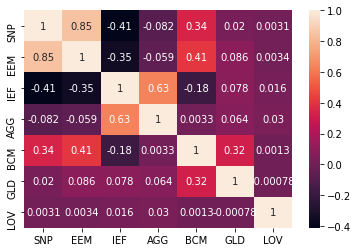

In [90]:
sns.heatmap(df.corr(),annot=True);

> __Correlation__ 
>- Equities (SNP, EEM) have a high correlation
>- Equities (SNP, EEM) have a slight negative correlation to the risk-free return (IEF) (? due to substitution effect?)
>- Fixed Income (IEF, AGG) have a correlation
>- Fixed Income (IEF, AGG) have no to negative correclation with commodities
>- Commodities and gold have a small correlation
>- long vol is least correlated to all portfolios

### Expected Return

SNP    0.099373
EEM    0.071725
IEF    0.045498
AGG    0.039244
BCM   -0.026379
GLD    0.082236
LOV    0.039436
dtype: float64

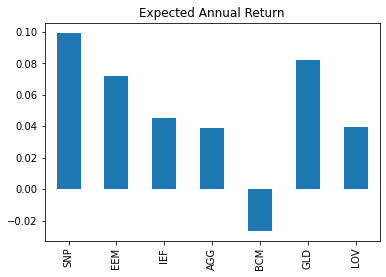

In [94]:
# get average daily return times 250 trading days a year
e_r = df.mean()*250

# plot exp return
e_r.plot(kind='bar')
plt.title('Expected Annual Return');

e_r

> __Returns__
> - SNP highest, Commodities lowest.
> - risk-free rate(IEF) is still higher than investment grade bonds
> - long-vol still outperforms commodities
> - although EEM has the highest vol it doesnt have the highest returns which should not be expected because higher volatility or risk is associated with more returns

### Positive and Negative months

In [98]:
for col in df.columns:
    new_col = col + '_sign'
    df[new_col] = np.sign(df[col])

In [114]:
for col in df.columns:
    if '_sign' in col:
        print(df[col].value_counts(normalize=True),'\n')

 1.0    0.555397
-1.0    0.443891
 0.0    0.000712
Name: SNP_sign, dtype: float64 

 1.0    0.530486
-1.0    0.462159
 0.0    0.007355
Name: EEM_sign, dtype: float64 

 1.0    0.523843
-1.0    0.466429
 0.0    0.009727
Name: IEF_sign, dtype: float64 

 1.0    0.535469
-1.0    0.448873
 0.0    0.015658
Name: AGG_sign, dtype: float64 

 1.0    0.508897
-1.0    0.485172
 0.0    0.005931
Name: BCM_sign, dtype: float64 

 1.0    0.506999
-1.0    0.459786
 0.0    0.033215
Name: GLD_sign, dtype: float64 

 0.0    0.952313
 1.0    0.024911
-1.0    0.022776
Name: LOV_sign, dtype: float64 



# Portfolio construction

In [ ]:
p_ret = []
p_weights = []
p_vol = []

num_assets = len(df_px.columns)
num_portfolios = 10_000_000

for portfolio in range(num_portfolios):
    #weights = [.25,.75]
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    returns = np.dot(weights,e_r)
    p_ret.append(returns)
    
    var = cov_matrix.mul(weights,axis=0).mul(weights,axis=1).sum().sum()
    ann_sd = np.sqrt(var*250)
    p_vol.append(ann_sd)
    
data = {'returns': p_ret, 'volatility': p_vol}

In [ ]:
for counter, symbol in enumerate(df_px.columns.tolist()):
    data[symbol + '_weight'] = [w[counter] for w in p_weights]
    
portfolios = pd.DataFrame(data)
portfolios

In [ ]:
# portfolios with lowest volatility
min_var_port = portfolios.loc[portfolios['volatility'].idxmin()]

portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
            color='r', marker='*', s=500);

In [ ]:
portfolios.to_csv('./data/portfolios.csv',index=False)